<a href="https://colab.research.google.com/github/rjy1022/my_assets/blob/main/Bayesian_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Aspects of this notebook have been adapted from the Neuromatch course materials [here](https://github.com/NeuromatchAcademy/course-content/blob/master/tutorials/README.md).*

**June** **Ro**

In [ ]:
#import useful libraries
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as random
import math

In [ ]:
#@title Figure Settings and helper functions
import ipywidgets as widgets
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/NMA2020/nma.mplstyle")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


def my_plot_single(x, px):
    """
    Plots normalized Gaussian distribution

    Args:
        x (numpy array of floats):     points at which the likelihood has been evaluated
        px (numpy array of floats):    normalized probabilities for prior evaluated at each `x`

    Returns:
        Nothing.
    """
    if px is None:
        px = np.zeros_like(x)

    fig, ax = plt.subplots()
    ax.plot(x, px, '-', color='C2', LineWidth=2, label='Prior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('Orientation (Degrees)')


def posterior_plot(x, likelihood=None, prior=None, posterior_pointwise=None, ax=None):
    """
    Plots normalized Gaussian distributions and posterior

    Args:
        x (numpy array of floats):         points at which the likelihood has been evaluated
        auditory (numpy array of floats):  normalized probabilities for auditory likelihood evaluated at each `x`
        visual (numpy array of floats):    normalized probabilities for visual likelihood evaluated at each `x`
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`
        ax: Axis in which to plot. If None, create new axis.

    Returns:
        Nothing.
    """
    if likelihood is None:
        likelihood = np.zeros_like(x)

    if prior is None:
        prior = np.zeros_like(x)

    if posterior_pointwise is None:
        posterior_pointwise = np.zeros_like(x)

    if ax is None:
      fig, ax = plt.subplots()

    ax.plot(x, likelihood, '-C1', LineWidth=2, label='Likeihood')
    ax.plot(x, prior, '-C0', LineWidth=2, label='Prior')
    ax.plot(x, posterior_pointwise, '--C2', LineWidth=2, label='Posterior')
    ax.legend()
    ax.set_ylabel('Probability')
    ax.set_xlabel('X')

    return ax


def plot_visual(mu_visuals, mu_posteriors, max_posteriors):
    """
    Plots the comparison of computing the mean of the posterior analytically and
    the max of the posterior empirically via multiplication.

    Args:
        mu_visuals (numpy array of floats): means of the visual likelihood
        mu_posteriors (numpy array of floats):  means of the posterior, calculated analytically
        max_posteriors (numpy array of floats): max of the posteriors, calculated via maxing the max_posteriors.
        posterior (numpy array of floats): normalized probabilities for the posterior evaluated at each `x`

    Returns:
        Nothing.
    """
    fig_w, fig_h = plt.rcParams.get('figure.figsize')
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_w, 2 * fig_h))

    ax[0].plot(mu_visuals, max_posteriors, '-C2', label='mean')
    ax[0].set_xlabel('Visual stimulus position')
    ax[0].set_ylabel('Multiplied posterior mean')
    ax[0].set_title('Sample output')

    ax[1].plot(mu_visuals, mu_posteriors, '--', color='xkcd:gray', label='argmax')
    ax[1].set_xlabel('Visual stimulus position')
    ax[1].set_ylabel('Analytical posterior mean')
    fig.tight_layout()
    ax[1].set_title('Hurray for math!')


def multimodal_plot(x, example_prior, example_likelihood,
                    mu_visuals, posterior_modes):
  """Helper function for plotting Section 4 results"""

  fig_w, fig_h = plt.rcParams.get('figure.figsize')
  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(fig_w, 2*fig_h), sharex=True)

  # Plot the last instance that we tried.
  posterior_plot(x,
    example_prior,
    example_likelihood,
    compute_posterior_pointwise(example_prior, example_likelihood),
    ax=ax[0]
    )
  ax[0].set_title('Example combination')

  ax[1].plot(mu_visuals, posterior_modes, '-C2', label='argmax')
  ax[1].set_xlabel('Visual stimulus position\n(Mean of blue dist. above)')
  ax[1].set_ylabel('Posterior mode\n(Peak of green dist. above)')
  fig.tight_layout()

##The Gaussian Distribution

Bayesian analysis operates within the world of probability distributions. Although these distributions can take many forms, the Gaussian distribution is a very common choice. Because of the central limit theorem, many quantities are Gaussian-distributed. Gaussians also have some mathematical properties that permit simple closed-form solutions to several important problems. 

The equation for a Gaussian is:
$$
\mathcal{N}(\mu,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)
$$

<font color="blue">Question #1: Write a function ```y = my_gaussian(x,mu,sigma)```, where ```x``` is a 1-d array of values, ```mu``` is the mean of the distribution, ```sigma``` is the standard deviation, and ```y``` is the value of the prescribed Gaussian distribution at each value of ```x```.</font>

In [ ]:
#type your code for Question #1 here
def my_gaussian(x,mu,sigma):
  y = (1 / (np.sqrt(2 * np.pi * (sigma)))) * np.exp((-((x - mu)**2)) / (2 * sigma))
  return y

##Bayes' Theorem and the Gaussian Distribution

Bayes' rule tells us how to combine two sources of information: the prior (e.g., a noisy representation of our expectations about where the stimulus might come from) and the likelihood (e.g., a noisy representation of the stimulus position on a given trial), to obtain a posterior distribution taking into account both pieces of information. Bayes' rule states:

\begin{eqnarray}
\text{Posterior} = \frac{ \text{Likelihood} \times \text{Prior}}{ \text{Normalization constant}}
\end{eqnarray}

or, more explicitly:

\begin{eqnarray}
p(\text{Model}\vert\text{Data}) = \frac{ p(\text{Data}\vert \text{Model}) \times p(\text{Model})} { p(\text{Data})}
\end{eqnarray}

If $\mathcal{N}(\mu,\sigma^2)$ denotes a Gaussian distribution with parameters $\mu$ and $\sigma^2$, then if both the prior and likelihood are Gaussians, this translates into the following form:

$$
\begin{array}{rcl}
\text{Likelihood} &=& \mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \\
\text{Prior} &=& \mathcal{N}(\mu_{prior},\sigma_{prior}^2) \\
\text{Posterior} &=& \frac{\mathcal{N}(\mu_{likelihood},\sigma_{likelihood}^2) \times \mathcal{N}(\mu_{prior},\sigma_{prior}^2)}{p(\text{Data})} 
\end{array}
$$

It turns out that for multiplying two Gaussians, this can be re-written as:

$$
\begin{array}{rcl}
&&= \mathcal{N}\left( \frac{\sigma^2_{likelihood}\mu_{prior}+\sigma^2_{prior}\mu_{likelihood}}{\sigma^2_{likelihood}+\sigma^2_{prior}}, \frac{\sigma^2_{likelihood}\sigma^2_{prior}}{\sigma^2_{likelihood}+\sigma^2_{prior}} \right) 
\end{array}.
$$

<font color="blue">Question #2: Write a function, ```posterior = calculateGaussianPosterior(x,mu_likelihood,sigma_likelihood,mu_prior,sigma_prior)``` that computes the posterior distribution for the data points ```x```. </font>

In [ ]:
#Type your code for Question #2 here
def calculateGaussianPosterior(x,mu_likelihood,sigma_likelihood,mu_prior,sigma_prior):
  mu = (sigma_likelihood * mu_prior + sigma_prior * mu_likelihood) / (sigma_likelihood + sigma_prior)
  sigma = (sigma_likelihood * sigma_prior) / (sigma_likelihood + sigma_prior)
  return my_gaussian(x, mu, sigma)

<font color="blue">Question #3: Write code to check that the distribution you generate from the function in Question #2 is normalized (i.e., $\int_{-\infty}^\infty \text{Posterior}(x) = 1$). </font>

In [ ]:
#Type you code for Question #3 here
x = np.arange(-1000, 1000, .01)
y = calculateGaussianPosterior(x, 4, .5, 4, .5) * 0.01
np.sum(y)

1.0000000000009097

## Interactive Demo: What affects the posterior?

Now that we can compute the posterior of two Gaussians with *Bayes rule*, let's vary the parameters of those Gaussians to see how changing the prior and likelihood affect the posterior. 

**Hit the Play button or Ctrl+Enter in the cell below** and play with the sliders to get an intuition for how the means and standard deviations of prior and likelihood influence the posterior. 

In [ ]:
#@title
#@markdown Make sure you execute this cell to enable the widget!

x = np.arange(-10, 11, 0.1)

import ipywidgets as widgets

def refresh(mu_auditory=3, sigma_auditory=1.5, mu_visual=-1, sigma_visual=1.5):
    auditory = my_gaussian(x, mu_auditory, sigma_auditory)
    visual = my_gaussian(x, mu_visual, sigma_visual)
    posterior_pointwise = visual * auditory
    posterior_pointwise /= (posterior_pointwise.sum()*(x[1]-x[0]))

    w_auditory = (sigma_visual** 2) / (sigma_auditory**2 + sigma_visual**2)
    theoretical_prediction = mu_auditory * w_auditory + mu_visual * (1 - w_auditory)

    ax = posterior_plot(x, auditory, visual, posterior_pointwise)
    ax.plot([theoretical_prediction, theoretical_prediction],
            [0, posterior_pointwise.max() * 1.2], '-.', color='xkcd:medium gray')
    ax.set_title(f"Gray line shows analytical mean of posterior: {theoretical_prediction:0.2f}")
    plt.show()

style = {'description_width': 'initial'}

_ = widgets.interact(refresh,
    mu_auditory=widgets.FloatSlider(value=2, min=-10, max=10, step=0.5, description="mu_likelihood:", style=style),
    sigma_auditory=widgets.FloatSlider(value=1, min=0.5, max=10, step=0.5, description="sigma_likelihood:", style=style),
    mu_visual=widgets.FloatSlider(value=-2, min=-10, max=10, step=0.5, description="mu_prior:", style=style),
    sigma_visual=widgets.FloatSlider(value=1, min=0.5, max=10, step=0.5, description="sigma_prior:", style=style)
)

interactive(children=(FloatSlider(value=2.0, description='mu_likelihood:', max=10.0, min=-10.0, step=0.5, styl…

<font color="blue">Question #4: Starting from $\sigma_{\text{likelihood}}= \sigma_{\text{prior}}=1$, $\mu_{\text{likelihood}}= 2$, and $\mu_{\text{prior}}=-2$, what happens to the posterior distribution as $\sigma_{\text{prior}}$ increases?  Explain why you think that the observed effect is occuring.</font>

<font color="green"> Type your answer to Question #4 here.

As we increase sigma_prior, we just start "trusting" the likelihood more because it has a smaller standard deviation. This can be seen in the equation where sigma_prior * mu_likelihood is then weighted more than sigma_likelihood * mu_prior. These values help determine the resulting mu of the gaussian, and therefore the mu moves toward our Likelihood gaussian as sigma_prior increases. </font>

<font color="blue">Question #5: Find a combination of parameters where the posterior distribution is visually indistinguishable from the prior distribution.  Explain why this combination of parameters results in little or no information from the likelihood being incorporated into the posterior. </font>

<font color="green"> Type your answer to Question #5 here.

Based on the equation, making sigma_prior equal to 0.50 and sigma_likelihood equal to 10 will make the likelihood as unimportant to the posterior as possible. Mu for either prior or likelihood can be set to anything, as the posterior will just follow the prior distribution around. If we could make sigma_prior = 0, this effect would be total. </font>

##Example: Neuronal tuning curves

As described in lecture last week, many neurons can be modeled as having *receptive fields* - meaning that they have different firing properties in response to different stimuli.  There are many examples of this, from vision to hearing to direction to location, and their discovery has been feted with two different Nobel Prizes for Physiology and Medicine ([1981](https://www.nobelprize.org/prizes/medicine/1981/summary/) and [2014](https://www.nobelprize.org/prizes/medicine/2014/summary/)).  Thinking about (simplified) versions of these cells are a great example of Bayesian inference, as an animal needs to incorporate the new information provided about its surrounding environment that these cells provide (the likelihood) into its existing world view (the prior). 

For today, we will focus on head direction cells.  These are neurons that fire when an animal is facing in a particular direction (e.g., north or east northeast).  Specifically, we will model these cells having a peaked *firing rate* curve around an angle, $\theta_k$.  That is, when the animal is pointed in direction $\theta_k$, the neuron will be most likely to fire, and this rate will decrease as one turns away from this direction.  We will call this curve $f_k(\theta)$.

For simplicity, we would typically want to model $f_k(\theta)$ as a 1-dimensional Gaussian, but the fact that our data is on a circle means that we need $f_k(\theta) = f_k(\theta+2\pi)$, which is not true for a Gaussian.  Thus, we will use the "Gaussian on a circle" - more officially known as the von Mises distribtuion:
\begin{equation}
f_k(\theta) = r_{max}e^{\kappa \cos(\theta-\theta_k)-\kappa},
\end{equation}
where $\kappa$ is a measure of how peaked the distribution is (think: something akin to the inverse of $\sigma$ for a Gaussian), and $r_{max}$ is the maximum firing rate.

The following code defines ```tuningCruve(theta,thetak,kappa,rmax)``` (parameter names are in argreement with the equation above) that computes the von Mises tuning curve above for an array of values (```theta```).  Note plotted curves widen as $\kappa$ decreases.

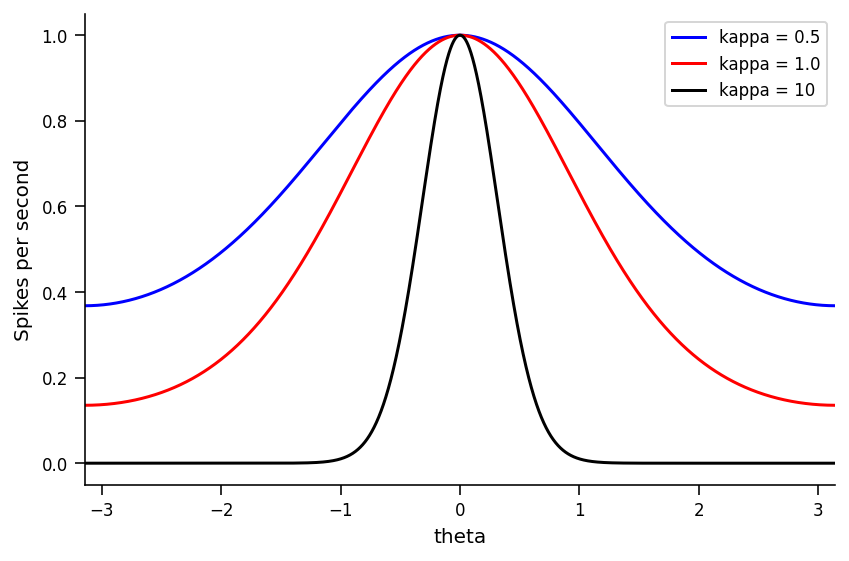

In [ ]:
def tuningCurve(theta,thetak=0,kappa=1,rmax=10):
    return rmax*np.exp(kappa*np.cos(theta-thetak)-kappa)

xx = np.arange(-np.pi,np.pi,.001)

fig, ax = plt.subplots()
thetak = 0
rmax = 1
kappas = [.5, 1, 10]
plt.plot(xx,tuningCurve(xx,thetak,kappas[0],rmax),'b-')
plt.plot(xx,tuningCurve(xx,thetak,kappas[1],rmax),'r-')
plt.plot(xx,tuningCurve(xx,thetak,kappas[2],rmax),'k-')

ax.legend(['kappa = 0.5','kappa = 1.0','kappa = 10'])
plt.xlabel('theta')
plt.ylabel('Spikes per second')
plt.xlim([-np.pi,np.pi])

plt.show()

###Poisson Processes

While these curves represent the average number of spike/second that a single neuron would provide in a time window, in any finite measuring window, we are likely to measure a slightly different rate in any given instantiation due to random noise.  For today, we will model the arrival of spikes as being given by a *Poisson process*.  In this process, we assume that for any time interval, only the mean firing rate ($f_k(\theta)$) and the interval length ($\Delta t$) are needed to compute the expected number of spikes.  This implies that there are no weird complications like refractory periods or other types of time-dependency.  Of course, real neurons often behave in much different ways than this, but we'll stick with this fantasy for now for the sake of simplicity.

Given that there is a Poisson process, the probability of observing $n$ spikes in time interval $\Delta t$ from neuron $k$, when the animal is facing in direction $\theta$ is:
\begin{equation}
p(\text{# spikes = }n \vert \theta) = \frac{(f_k(\theta )\Delta t)^{n\Delta t}}{(n\Delta t)!}e^{-f_k(\theta)\Delta t}.
\end{equation}

<font color="blue"> Question #6: Write a function (```returnPoissonDraws(deltaT)```) that returns 10,000 random draws from the above Poisson distribution at $\theta = \theta_k$ as a function of $\Delta t$ (you can assume $\kappa = r_{max} = 10$).  Histogram these draws for $\Delta t = .01$ and $\Delta t = 10$.  Describe and analyze the differences between the found distributions.  (Note: ```random.poisson()``` will be helpful)</font>

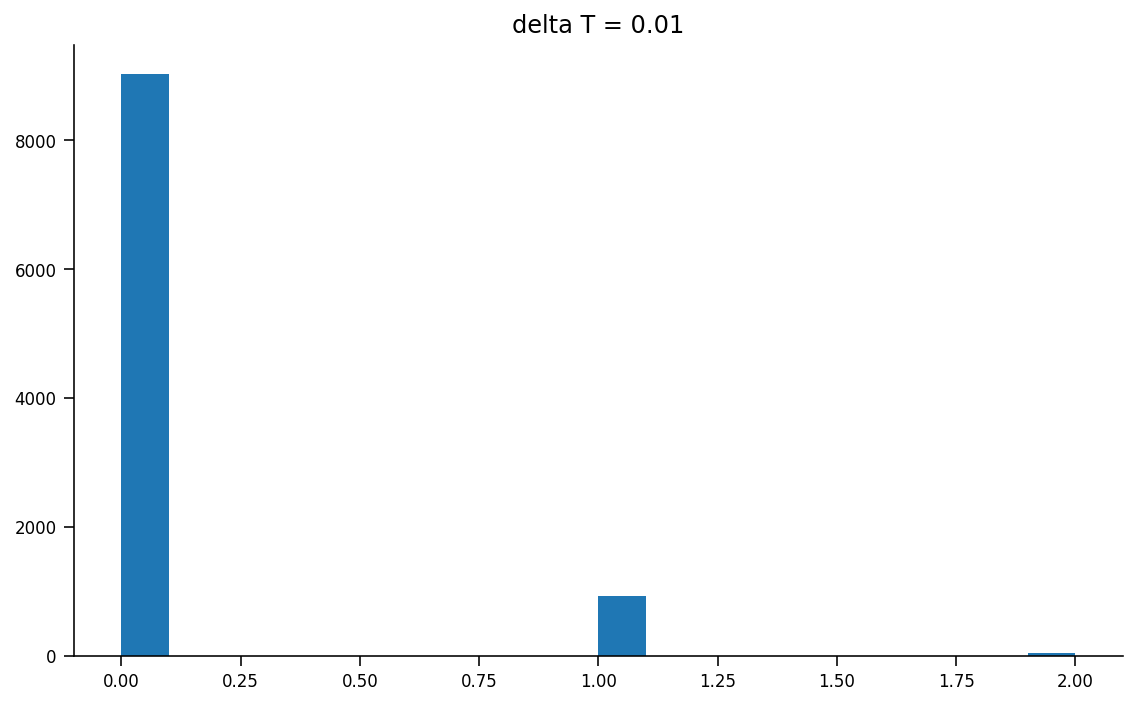

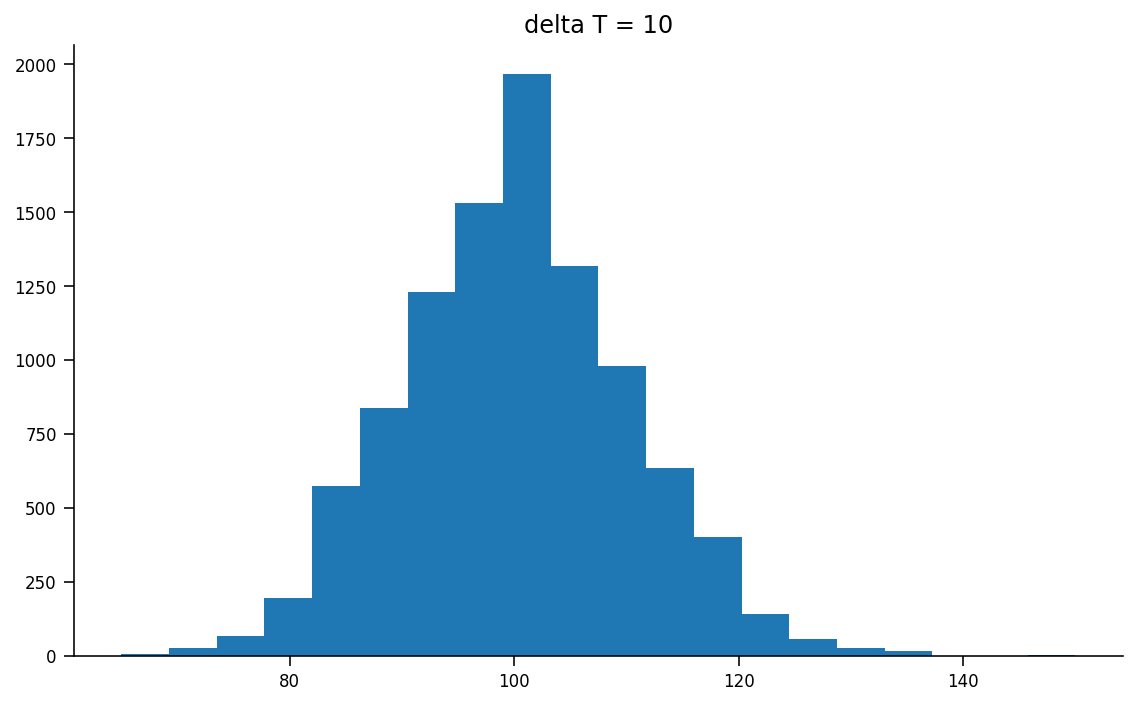

In [ ]:
#Type your code for Question #6 here
theta = 0
theta_k = 0
kappa = 10
rmax = 10

def returnPoissonDraws(deltaT): 
  return random.poisson(((tuningCurve(theta, theta_k, kappa, rmax)*deltaT)), size = (10000,1))

deltat1 = returnPoissonDraws(.01)
plt.figure(figsize=(8, 5))
plt.hist(deltat1, bins=20)
plt.title('delta T = 0.01')
plt.show()

deltat2 = returnPoissonDraws(10)
plt.figure(figsize=(8, 5))
plt.hist(deltat2, bins=20)
plt.title('delta T = 10')
plt.show()

<font color="green">Describe and analyze the differences between the found distributions.

The number of spikes for the time interval 0.01 shows an extremely right-skewed distribution whereas that for the time interval 10 shows a relatively normally distributed histogram. In fact, the number of spikes for the time interval 0.01 is mostly 0, and this may be because time interval of 0.01 is too short to observe a spike of a neuron k. Delta T of 10 is reasonably long enough, such that we can observe a normally distributed data on the number of spikes of neuron k. </font>

##Calculating the Likelihood

Thus, given an equation for $p(\text{# spikes = }n \vert \theta)$ in $\Delta t$, we can now write  $p(\text{rate = }r \vert \theta) = \frac{(f_k(\theta )\Delta t)^{r\Delta t}}{(r\Delta t)!}e^{-f_k(\theta)\Delta t}$, where $r$ is the number of spikes observed in $\Delta t$, divided by $\Delta t$.

<font color="blue"> Question #7: Write a function to calculate the likelihood of observing firing rate $r$ across $\theta$ from $-\pi$ to $\pi$ (i.e., $p(r\vert \theta)$).  Assume that $\Delta t = 0.1$, $\theta_k = 0$, $r_{max}=60$, and $\kappa = 4$.  Note: you can implement $x!$ in python as ```math.gamma(x+1)```.  Plot curves for $r = 60$ and $r=10$ (using ```thetas = np.arange(-np.pi,np.pi,.001)```).  Describe why you are getting rather different-looking result for the two curves.

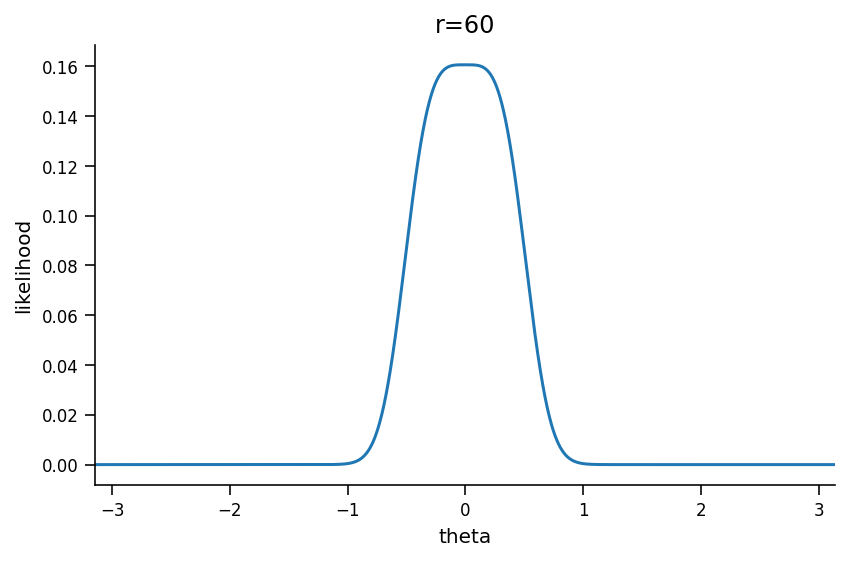

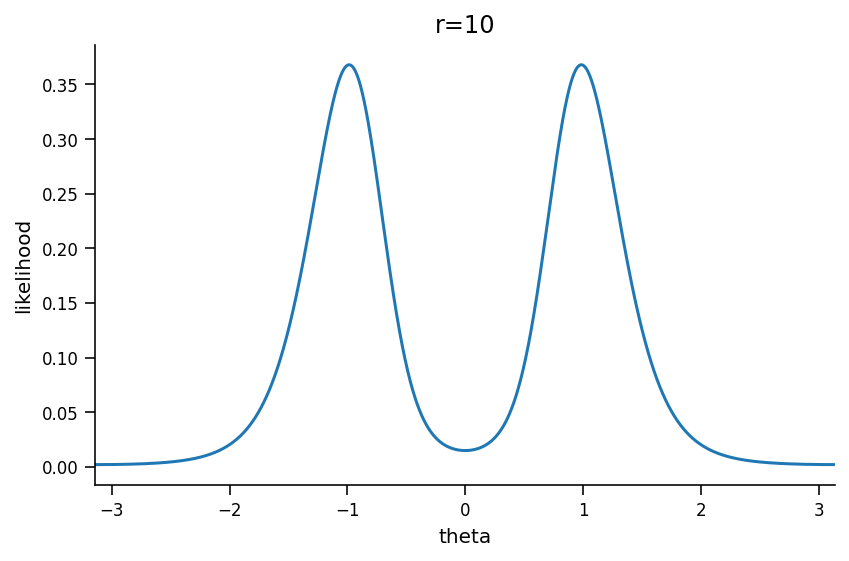

In [ ]:
#Type your code for Question #7 here
deltaT = 0.1
theta_k = 0
rmax = 60
kappa = 4
theta = np.arange(-np.pi, np.pi, .001)

def calculateLikelihood(theta,rate,theta_k,kappa,deltaT,rmax):
  return (((tuningCurve(theta, thetak, kappa, rmax)*deltaT) ** (rate*deltaT)) / (math.gamma((rate * deltaT)+1)) * (np.exp(-tuningCurve(theta, thetak, kappa, rmax)*deltaT)))

  
fig, ax = plt.subplots()

plt.plot(theta,calculateLikelihood(theta,60,theta_k,kappa,deltaT,rmax))
plt.xlabel('theta')
plt.ylabel('likelihood')
plt.xlim([-np.pi,np.pi])
plt.title('r=60')
plt.show()

plt.plot(theta,calculateLikelihood(theta,10,theta_k,kappa,deltaT,rmax))
plt.xlabel('theta')
plt.ylabel('likelihood')
plt.xlim([-np.pi,np.pi])
plt.title('r=10')
plt.show()




<font color="green">Describe why you are getting rather different-looking result for the two curves.

First of all, the scales of the two graphs are different and they read that the likelihood of observing a firing rate of 60 is lower than that for a firing rate of 10. Also, we see two spikes for r=10, perhaps because it is more probable to observe a firing rate of 10. When theta is 0, the animal fires at a rate of 60 but when it faces in the directions -1 and 1, it fires at a rate of 10.
</font>

##Calculating the Posterior

<font color="blue">Question #8: Given the equation for $p(r\vert\theta)$, if we assume that the prior distribution, $p(\theta)$, is given by another vonMises distribution,
\begin{equation}
p(\theta) = \frac{1}{2\pi I_0(\kappa_p)}e^{\kappa\cos(\theta-\theta_p)},
\end{equation}
write a function ```calculatePosterior(theta,rate,theta_k,kappa,deltaT,rmax,theta_prior,kappa_prior)``` that returns the value of the posterior function - $p(\theta | r)$ - for an array of ```theta``` values (don't worry about normalizing - just multiply the likelihood with the prior).  Note that $I_0(\kappa_p)$ is the 0th order modified Bessel function - it is just needed for normalization, so don't worry if you haven't seen it before -- and it can be implemented in python via ```np.i0(kappa_prior)```.</font>

In [ ]:
#Type your code for Question #8 here
def calculatePosterior(theta,rate,theta_k,kappa,deltaT,rmax,theta_prior,kappa_prior):
  prior = ((1 / (2*np.pi) * (np.i0(kappa_prior))) * (np.exp(kappa * np.cos(theta - theta_prior))))
  return calculateLikelihood(theta, rate, theta_k, kappa, deltaT, rmax) * prior 




<font color="blue"> Question #9: Using the same parameters as in Question #7, plot $p(\theta\vert r)$ for $\kappa_p = 0.1$ and $\theta_p = -1$ for both $r=60$ and $r=10$.  How do these results differ from your likelihood plots?  Why?

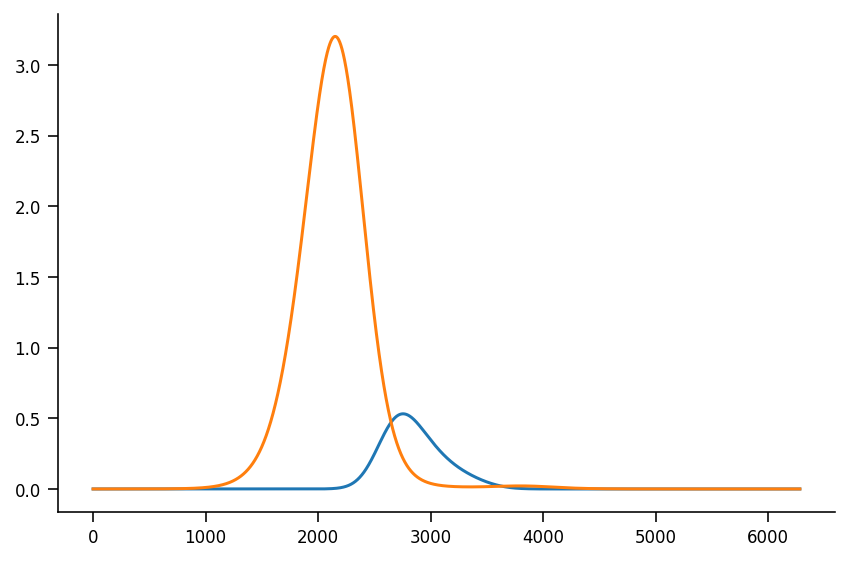

In [ ]:
rate60 = calculatePosterior(theta,60,theta_k,kappa,deltaT,rmax,-1,.1)
plt.plot(rate60, label = 'r=60') 

rate10 = calculatePosterior(theta,10,theta_k,kappa,deltaT,rmax,-1,.1)
plt.plot(rate10, label = 'r=10') 





<font color="green"> How do these results differ from your likelihood plots? Why? 

In contrast to the likelihood plots, the posterior plots for r=10 show only one peak. The plots look different because now the prior is taken into account.   </font>




<font color="blue"> Question #10: What happens to the posterior distributions if you decrease $\Delta t$ to be equal to 1 (keeping all other parameters constant).  Describe why this is happening.

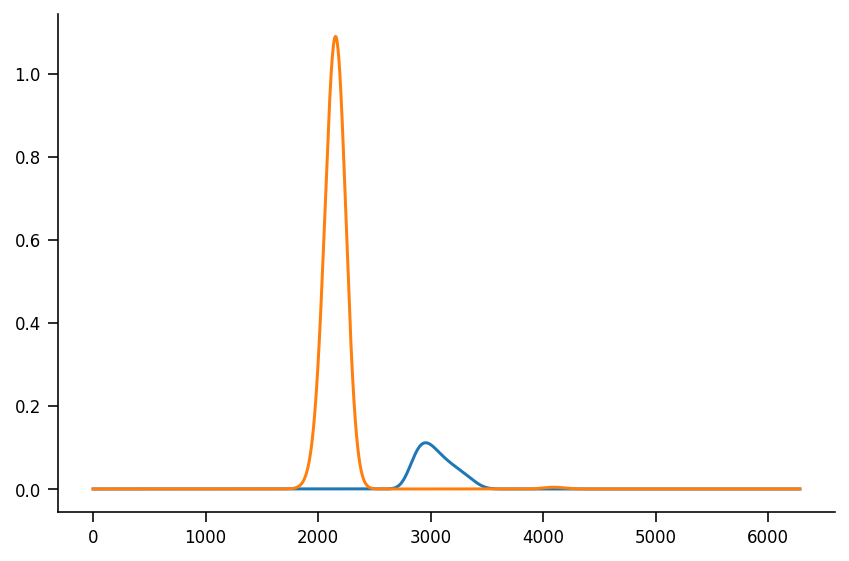

In [ ]:
rate60_new = calculatePosterior(theta,60,theta_k,kappa,1,rmax,-1,.1)
plt.plot(rate60_new, label = 'r=60')

rate10_new = calculatePosterior(theta,10,theta_k,kappa,1,rmax,-1,.1)
plt.plot(rate10_new, label = 'r=10')


<font color="green"> Describe why this is happening. 
The plots look narrower for deltaT=1 compared to deltaT=0.1. I manipulated deltaT values further to understand the distirbutions better, and smaller deltaT (0.0001) resulted in the two plots almost overlapping on one another and larger deltaT (2) resulted in the two plots being even farther from each other and narrower than deltaT value of 1. Larger deltaT implies that the likelihood value decreases, which is why the plots become narrower and smaller.
</font>